In [1]:
#General imports needed for path
import os 
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import mapping
import folium
import itertools

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Packages created by our group:
import route_dynamics.route_elevation.base_df as base
import route_dynamics.route_energy.knn as knn
from route_dynamics.route_riders import route_riders as ride
import route_dynamics.route_energy.longi_dynam_model as ldm
import route_dynamics.route_energy.accel as ca

In [4]:
#User defines what routes they want to evaluate
rt_list = [22,101,102,143,150,153,154,156,157,158,159,168,169,177,178,179,180,181,182,183,186,187,190,192]

route = rt_list[0]

time = 'MID' #AM, MID, PM, XEV, XNT
#Import route shapefile

shapefile_name = '../data/rt' + str(route) + '_pts2.shp'

#Import bus stops shapefile

stops_shp = '../data/Transit_Stops_for_King_County_Metro__transitstop_point.shp'

signals_shp = '../data/traffic_signals2.shp'

trip183 = pd.read_csv("../data/Trip183.csv", usecols = ['SignRt', 'InOut', 'KeyTrip', 'BusType', 'Seats', 
                     'Period', 'AnnRides']) # KCM Data
trip183unsum = pd.read_csv("../data/Zon183Unsum.csv", usecols = ['Route', 'Dir', 'Trip_ID', 'InOut', 'STOP_SEQ', 'STOP_ID',
                     'Period', 'AveOn', 'AveOff', 'AveLd', 'Obs'])

#Acceleration profile
a_prof = pd.read_csv("../data/acceleration.csv", names=['time (s)', 'accel. (g)'])

In [5]:
trip_df = ride.route_ridership(time, route, 14000)
geometry = trip_df.geometry.values
trip_df['AveLd'].mean()

3.146590909090909

notes:   
22 - AM (1.46), **MID (3.14)**, PM (8.23), XEV (2.29)  
101 - AM (23.6), MID (19.6), PM (24.4), XEV (14.3), **XNT(21.1)**  
102 - AM (19.6), MID (), **PM (15.4)**, XEV (0.56), XNT(9.3)  
143 - **AM (11.4)**, MID (), PM (16.4), XEV (1.74), XNT()  
150 - AM (14.2), **MID (18.1)**, PM (22.57), XEV (23.5), XNT(15.4)  
153 - AM (9.9), MID (6.0), **PM (8.4)**, XEV (4.7), XNT()  
154 - AM (12.6), MID (1.7), **PM (8.4)**, XEV (), XNT()  
156 - AM (3.1), MID (5.4), PM (7.1), XEV (3.7), **XNT(3.5)** 
157 - AM (13), MID (), **PM (16)**, XEV (), XNT()

In [6]:
xy = []
for i in range(len(geometry)):
    dic = mapping(geometry[i][0])
    coords = dic['coordinates']
    xy.append(coords)
    xy_df = pd.DataFrame(columns = ['STOP_ID','coordinates'])
    xy_df['coordinates'] = xy
    
xy_df

stop_coords = xy_df.coordinates.values

In [7]:
len(stop_coords)

88

In [8]:
signals = gpd.read_file(signals_shp)
signals = signals[signals['Route_Num']==str(route)]
geometry = signals.geometry.values
xy = []
for i in range(len(geometry)):
    dic = mapping(geometry[i])
    coords = dic['coordinates']
    xy.append(coords)
    xy_df = pd.DataFrame(columns = ['STOP_ID','coordinates'])
    xy_df['coordinates'] = xy
    
xy_df

signal_coords = xy_df.coordinates.values

In [9]:
len(signal_coords)

16

In [10]:
mass_array = trip_df.Total_Mass.values

In [11]:
ex = ldm.RouteTrajectory(
route,
shapefile_name,
a_prof,
stop_coords,
signal_coords,
mass_array = mass_array,
unloaded_bus_mass = 14000,
charging_power_max = 160000,
aux = 10000
)

In [12]:
rt_df = ex.route_df

In [13]:
rt_df.head()

,geometry,distance,elevation,speed_limit,grade,is_bus_stop,is_signal,is_stop,acceleration,velocity,delta_times,total_time,mass,grav_force,roll_fric,aero_drag,inertia,power_output
0,POINT (-122.38813 47.56295),0.0000,99.398090,11.175682,0.000000,False,False,False,0.000000,0.000000,0.000000,0.000000,14000.0,-0.000000,-1373.400000,-0.000000,0.000000,0.000000
1,POINT (-122.38798 47.56295),10.9728,99.874774,11.175682,0.043442,False,False,False,1.264274,3.186607,6.886949,6.886949,14000.0,-5960.746166,-1372.105867,-5.693782,17699.836163,79787.488819
2,POINT (-122.38784 47.56295),21.9456,100.272354,11.175682,0.036233,False,False,False,1.226868,4.815798,2.742425,9.629374,14000.0,-4973.011720,-1372.499354,-8.604796,17176.145379,113316.984141
3,POINT (-122.38769 47.56295),32.9184,100.594760,11.175682,0.029382,False,False,False,1.211556,5.766712,2.073799,11.703173,14000.0,-4033.625469,-1372.807542,-10.303875,16961.784873,129050.495139
4,POINT (-122.38754 47.56295),43.8912,100.845922,11.175682,0.022889,False,False,False,1.092837,7.085541,1.707560,13.410734,14000.0,-3142.818559,-1373.040360,-12.660339,15299.720907,140493.817179


In [14]:
rt_df['speed_limit'].mean()*2.23694

31.69976702152883

In [15]:
rt_df['speed_limit'].min()*2.23694

24.999329459097005

In [16]:
rt_df['speed_limit'].max()*2.23694

34.999061242735806

In [17]:
rt_df['total_time'].iloc[-1]/60

61.90091567944343

Text(0.5, 1, 'Load Profile for Route 22')

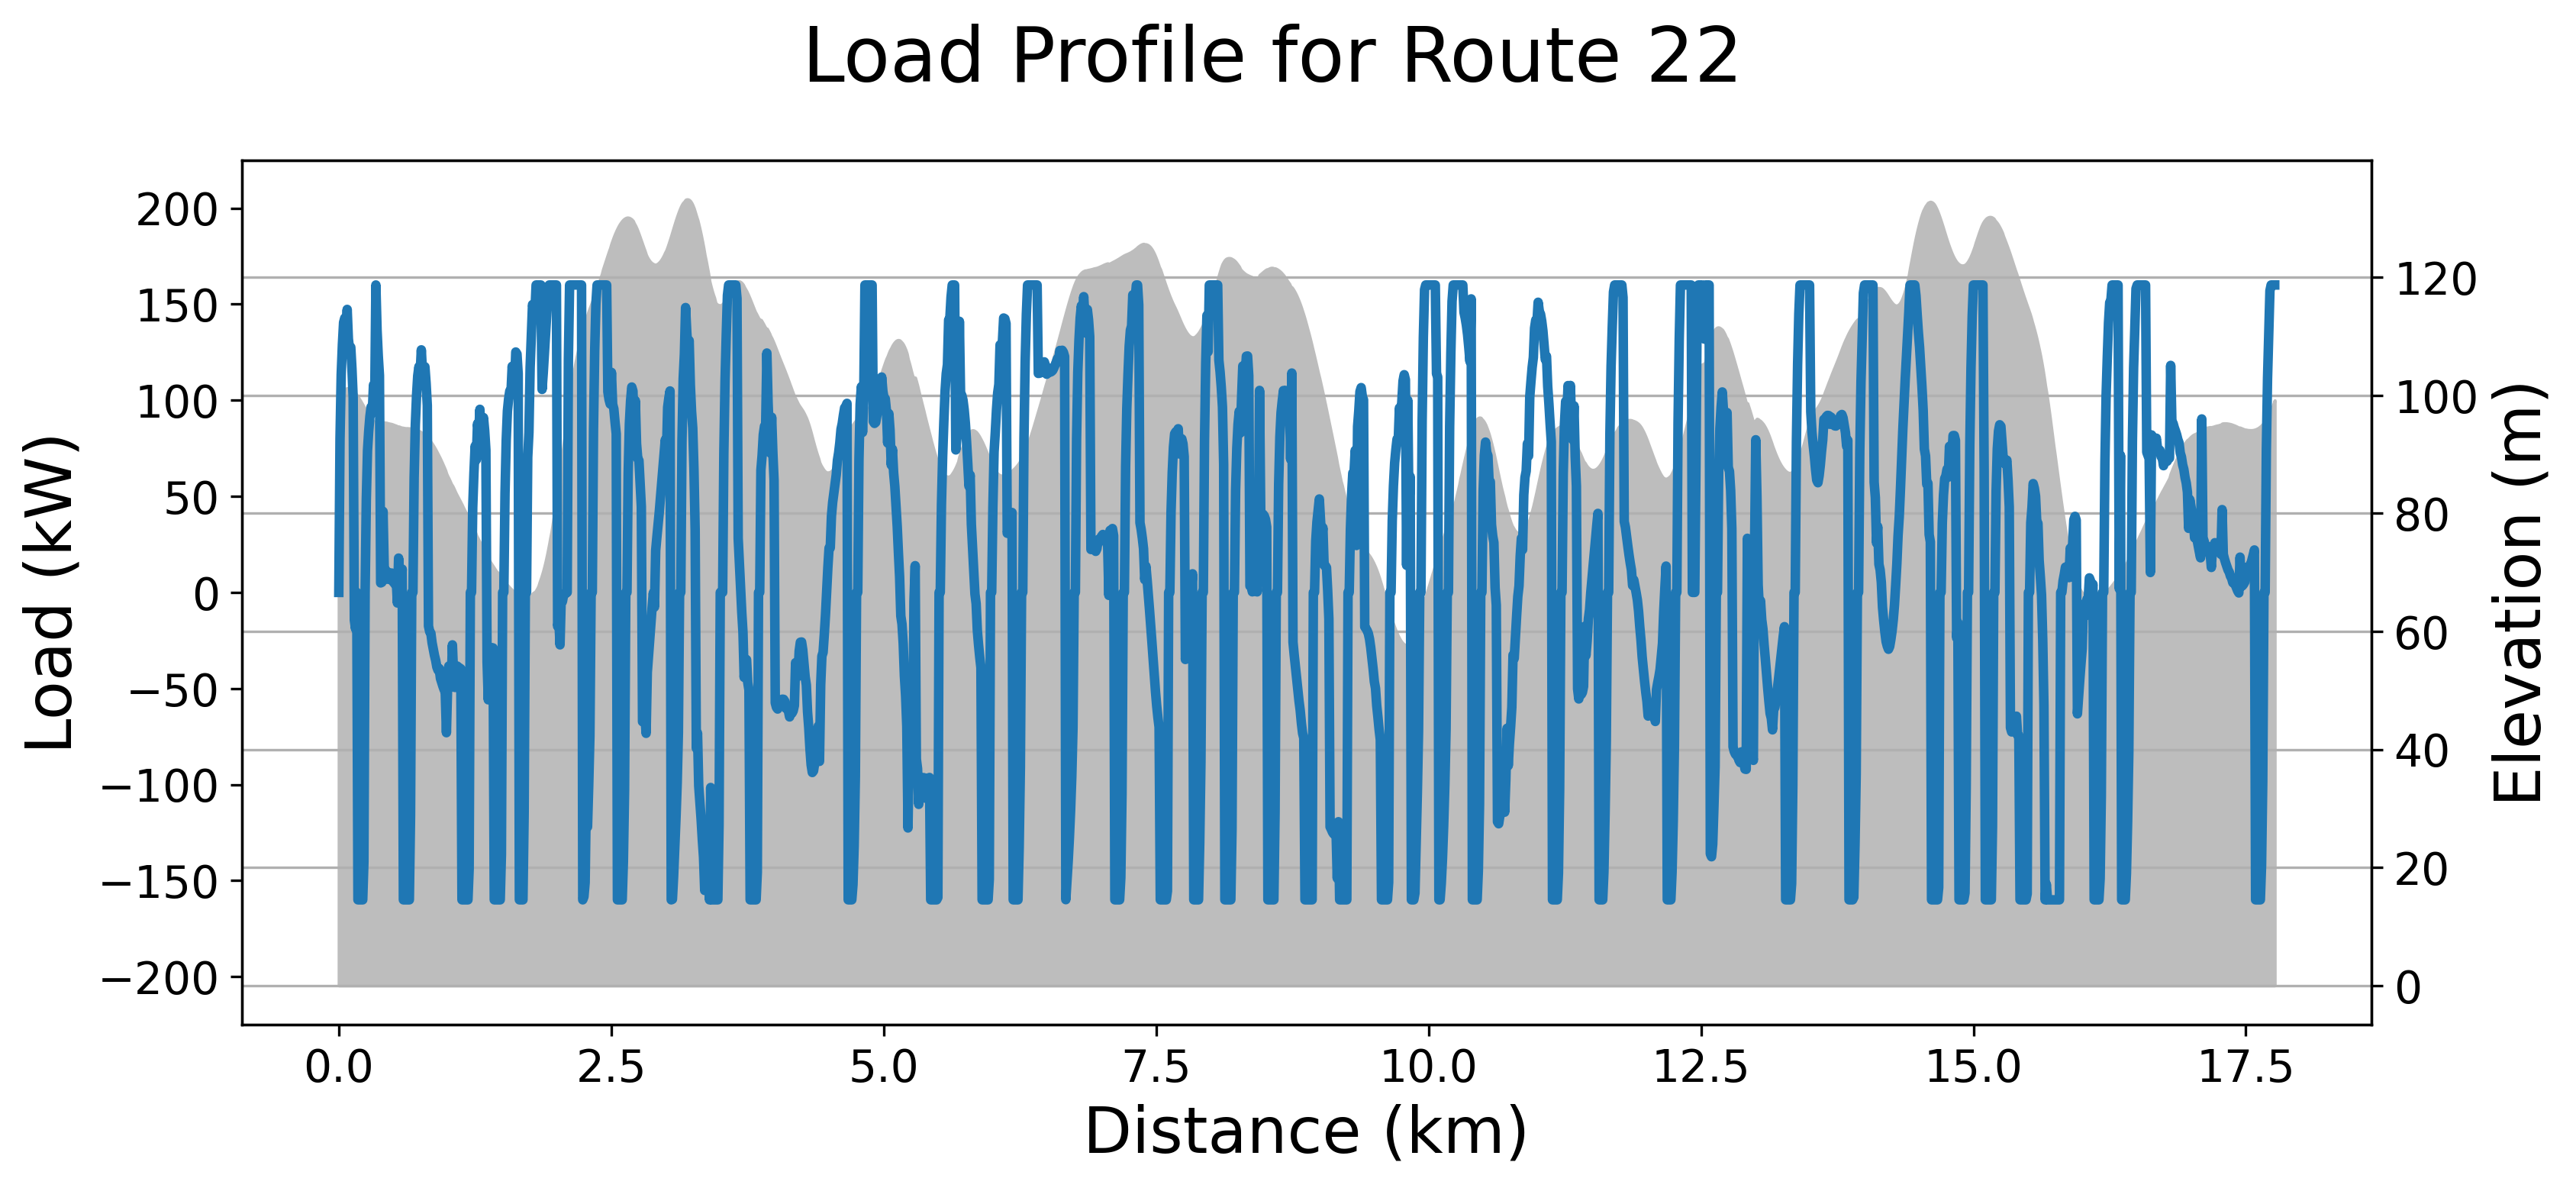

In [18]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

ax.fill_between(rt_df['distance']/1000, rt_df['elevation'], color='#BDBDBD')
ax1 = ax.twinx()

ax1.plot(rt_df['distance']/1000, rt_df['power_output']/1000, linewidth=3)
ax1.set_ylabel('Load (kW)', fontsize=20)
ax1.set_ylim(-225, 225)
ax.set_xlabel('Distance (km)', fontsize=20)
ax.set_ylabel('Elevation (m)', fontsize=20)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax1.yaxis.set_label_position("left")
ax1.yaxis.tick_left()

ax.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)
ax.grid(axis='y')

fig.suptitle(
    'Load Profile for Route {}'.format(route),
    fontsize=24,
    y=1,
    )


Text(0.5, 1, 'Load Profile for Route 22')

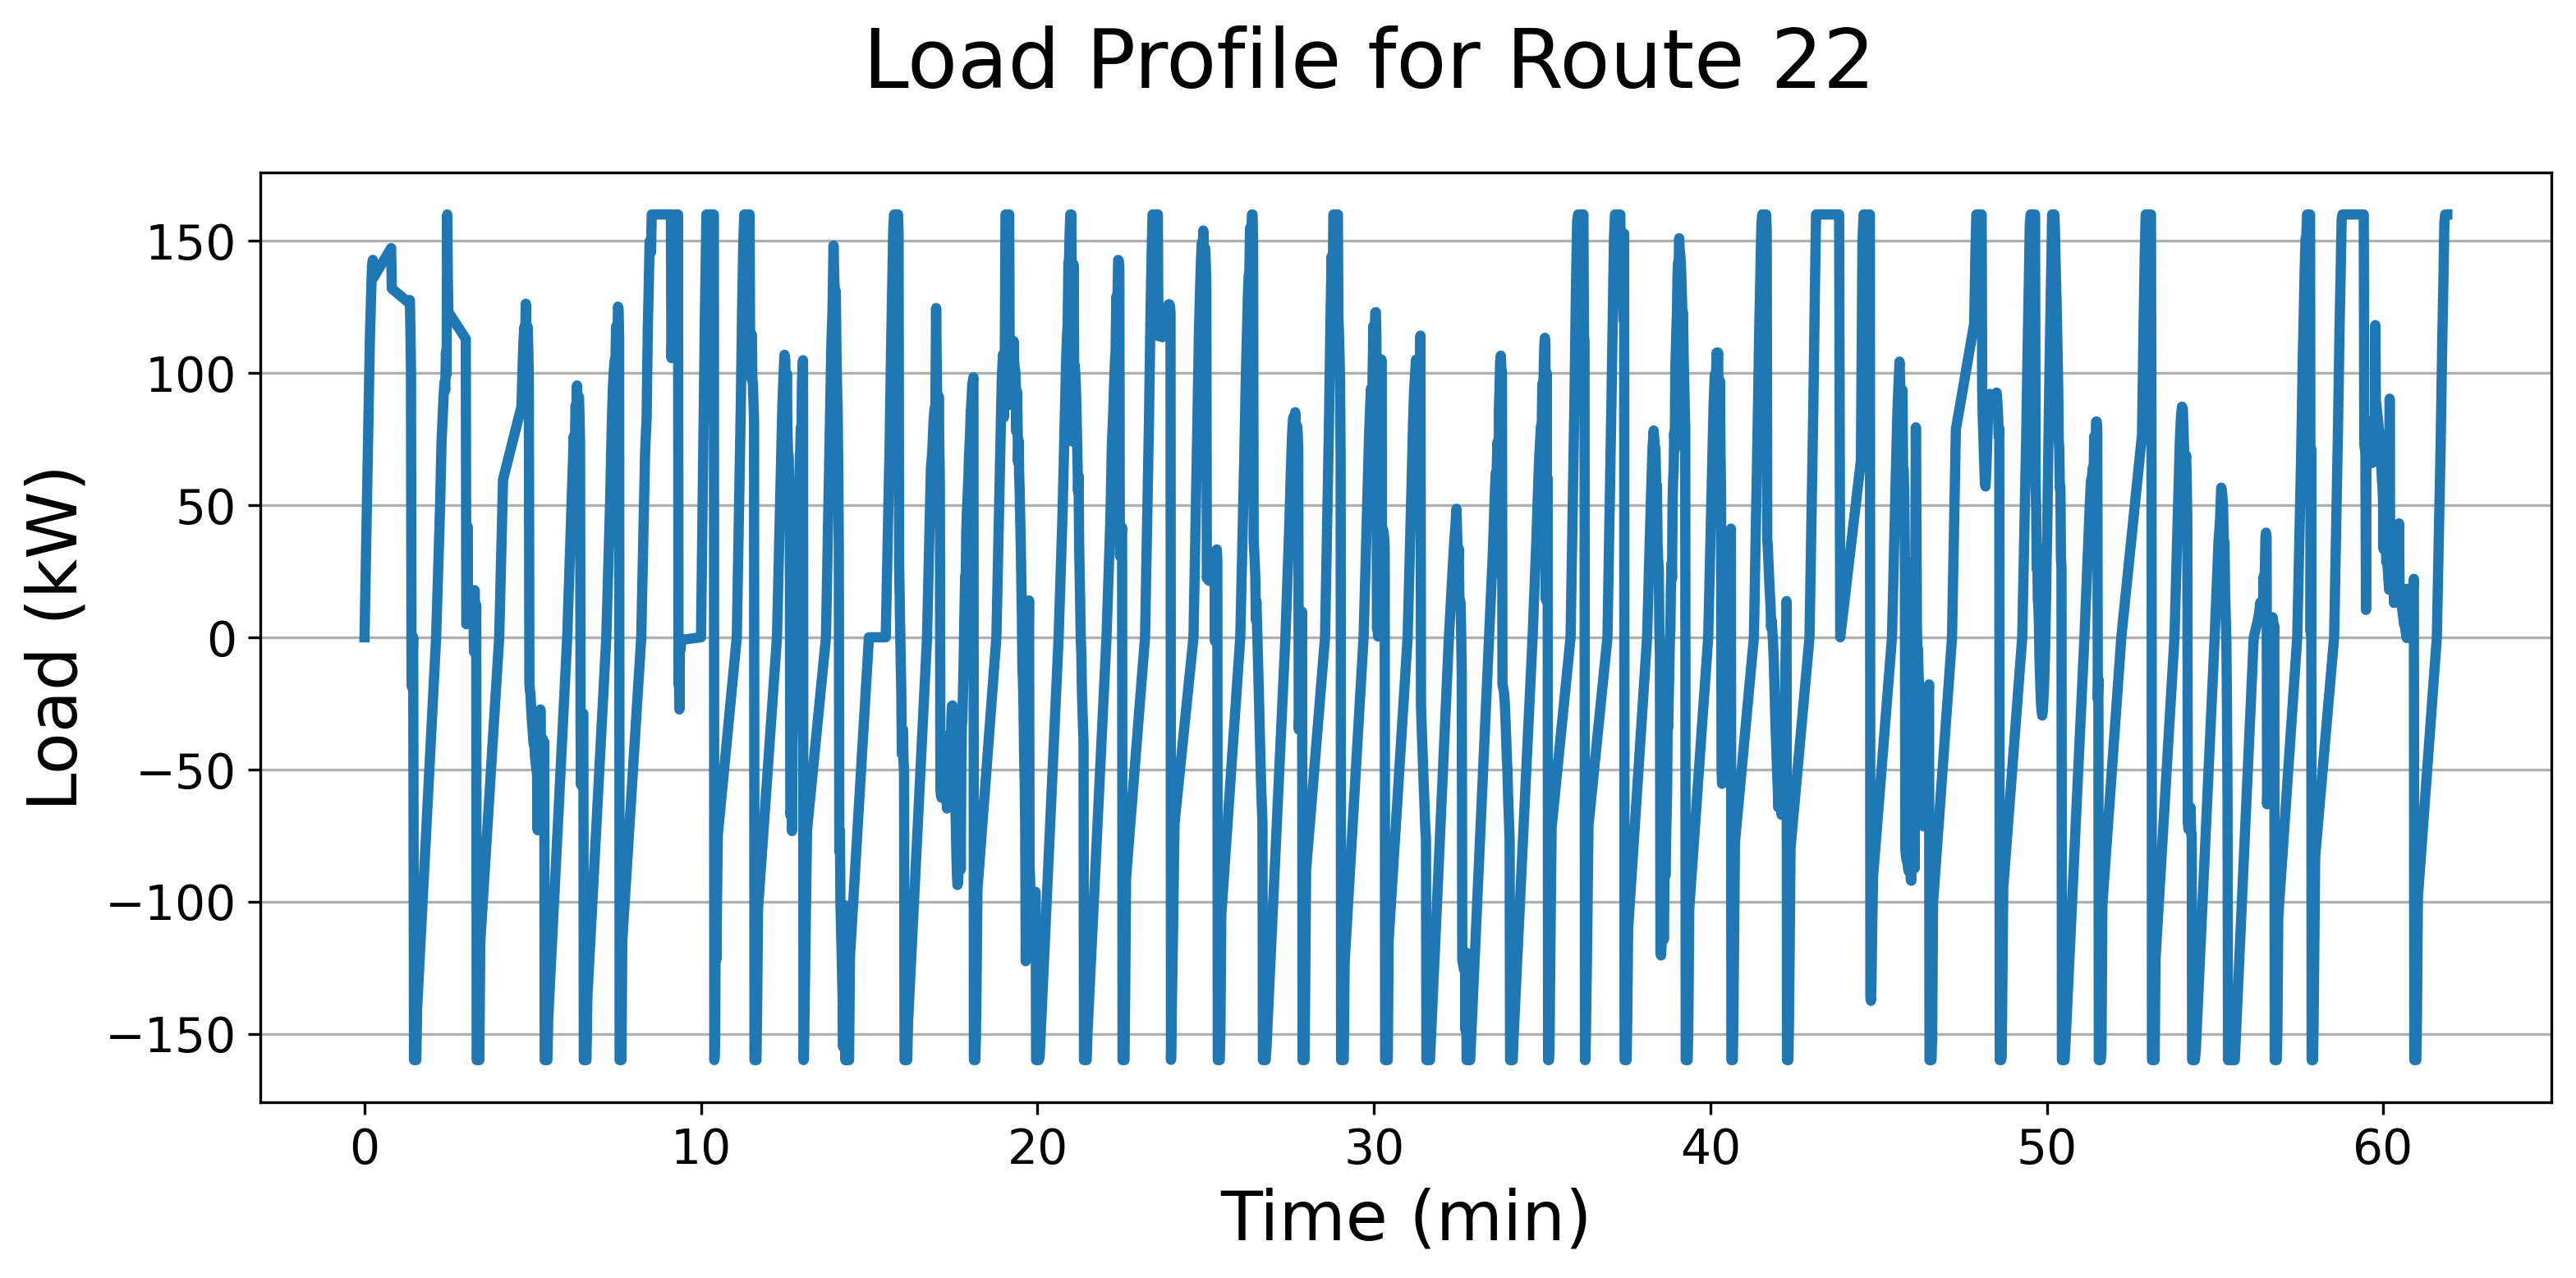

In [19]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

ax.plot(rt_df['total_time']/60, rt_df['power_output']/1000, linewidth=3)
ax.set_xlabel('Time (min)', fontsize=20)
ax.set_ylabel('Load (kW)', fontsize=20)
ax.tick_params(labelsize=14)
ax.grid(axis='y')

fig.suptitle(
    'Load Profile for Route {}'.format(route),
    fontsize=24,
    y=1,
    )

Text(0.5, 1, 'Histogram for Route 22')

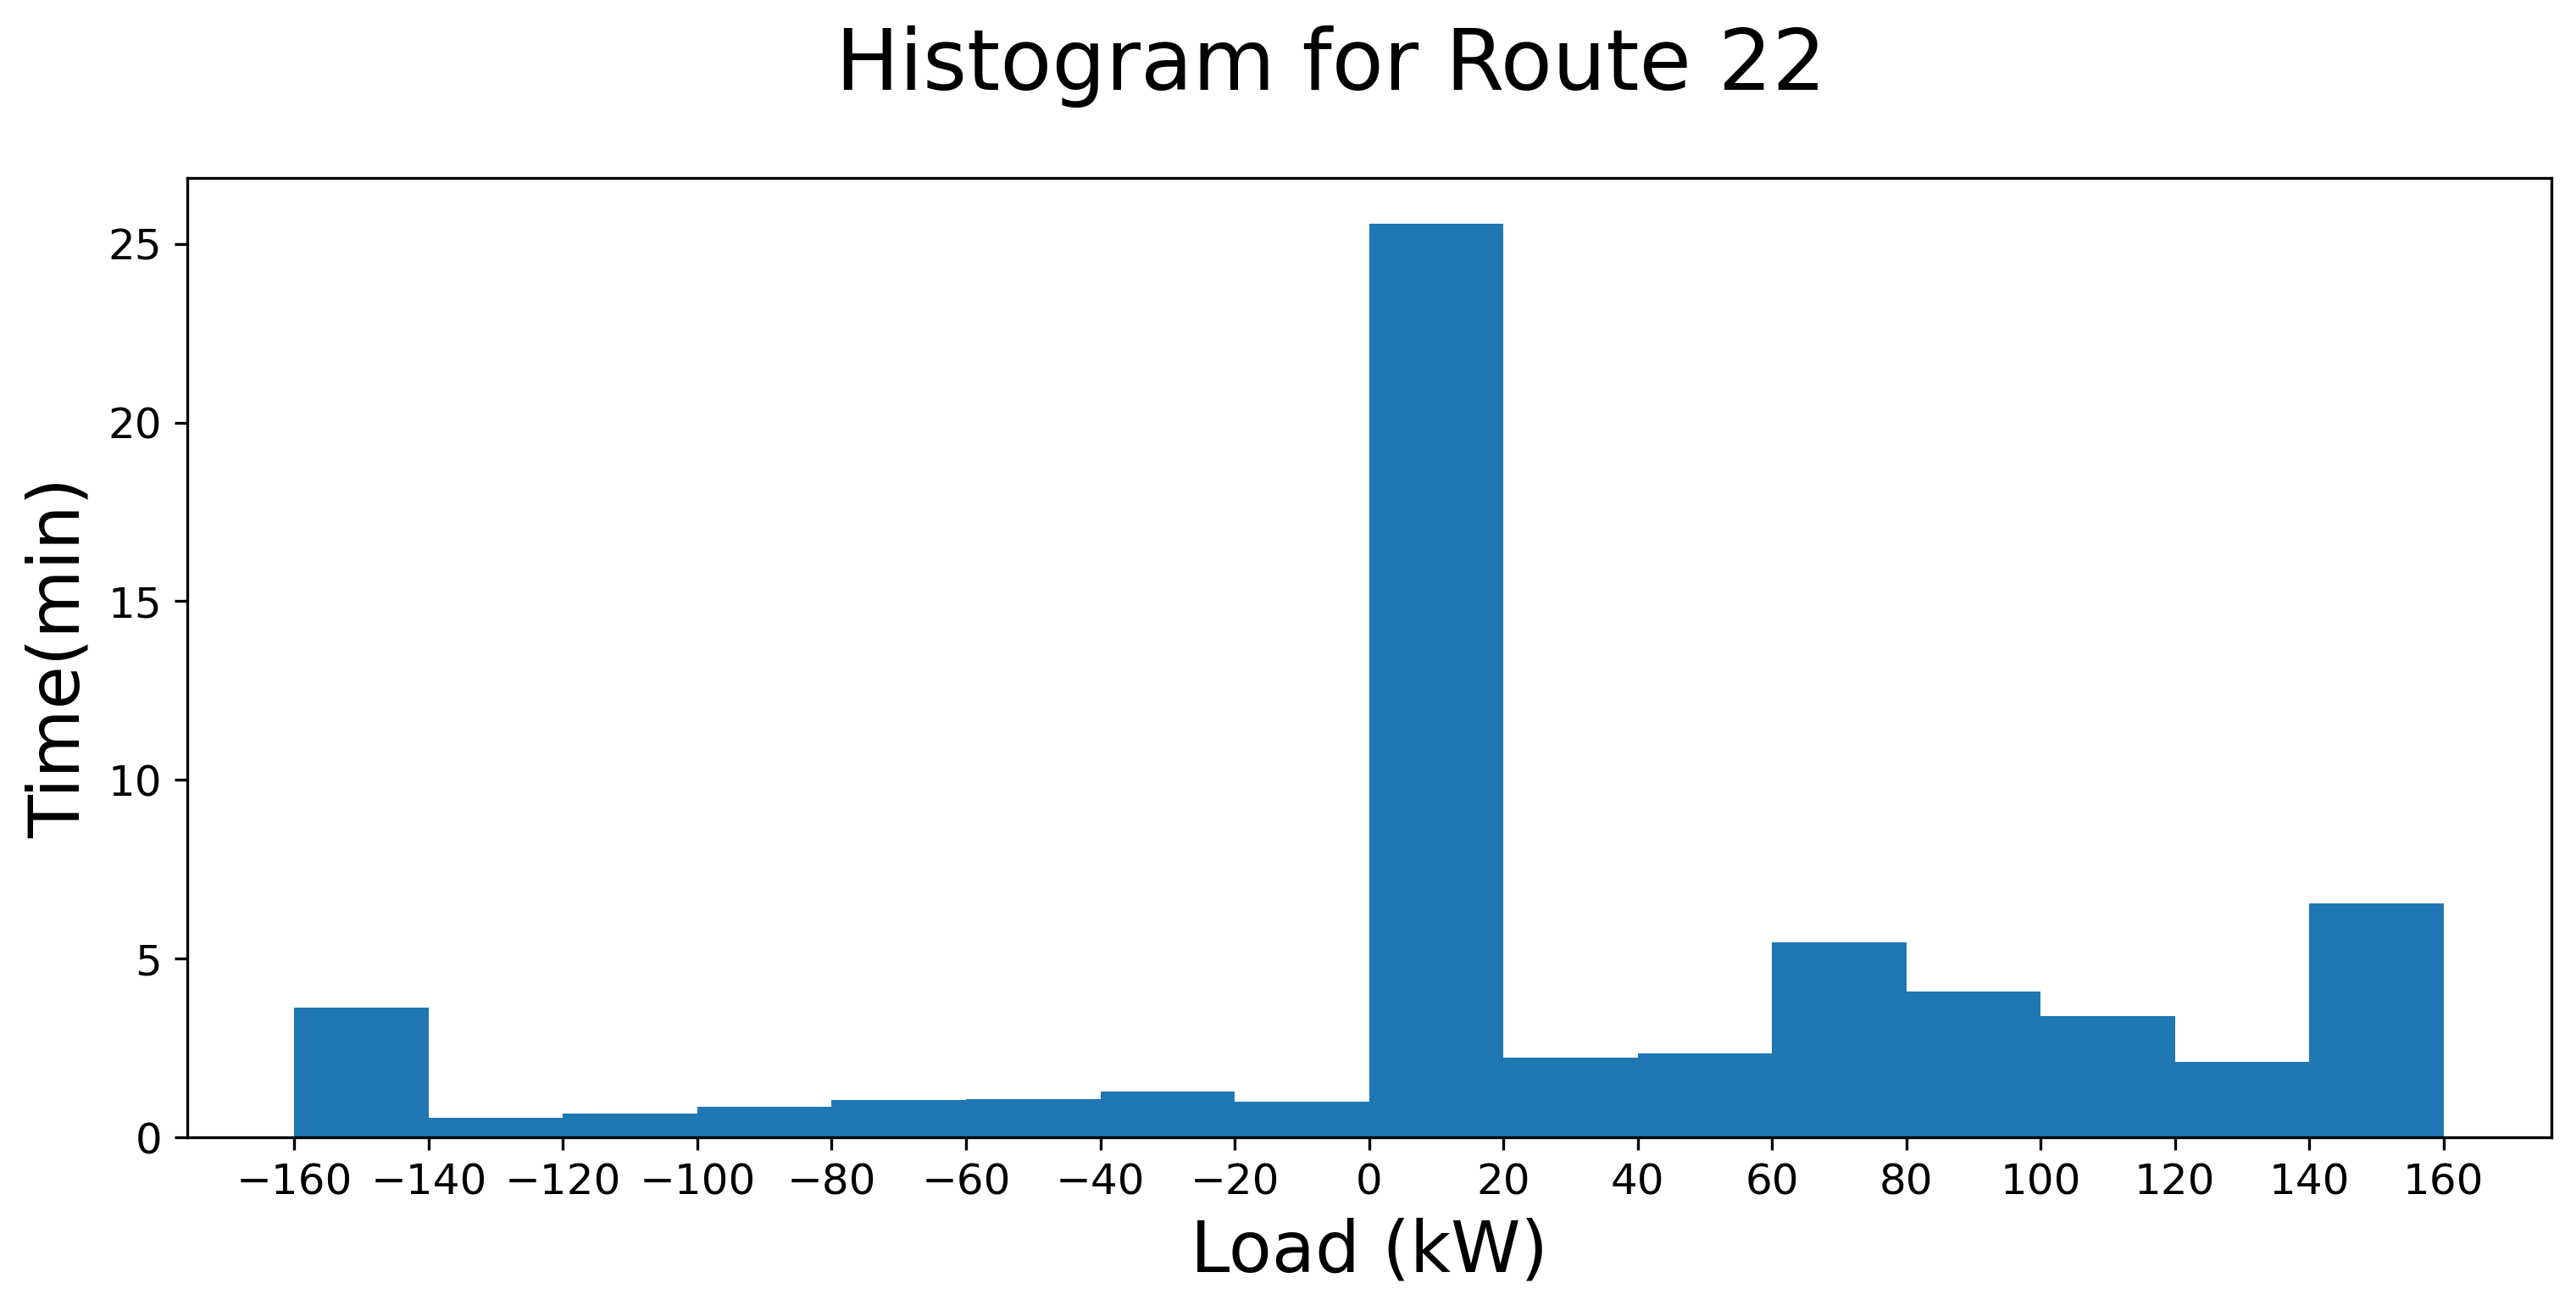

In [20]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

bins = [-160, -140, -120, -100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160]
ax.hist(rt_df['power_output']/1000, bins=bins, weights=rt_df['delta_times']/60)
ax.set_ylabel('Time(min)', fontsize=20)
ax.set_xlabel('Load (kW)', fontsize=20)
ax.tick_params(labelsize=12)
ax.set_xticks(bins)

fig.suptitle(
    'Histogram for Route {}'.format(route),
    fontsize=24,
    y=1,
    )

In [21]:
np.histogram(rt_df['power_output']/1000, bins=bins, weights=rt_df['delta_times']/60)

(array([ 3.63562689,  0.56045239,  0.6677273 ,  0.84697573,  1.051798  ,
         1.07988908,  1.29035159,  1.00669742, 25.56953022,  2.2416974 ,
         2.3533967 ,  5.46798063,  4.08450226,  3.38561468,  2.10436797,
         6.55430743]),
 array([-160, -140, -120, -100,  -80,  -60,  -40,  -20,    0,   20,   40,
          60,   80,  100,  120,  140,  160]))

Text(0.5, 1, 'Histogram for Route 22')

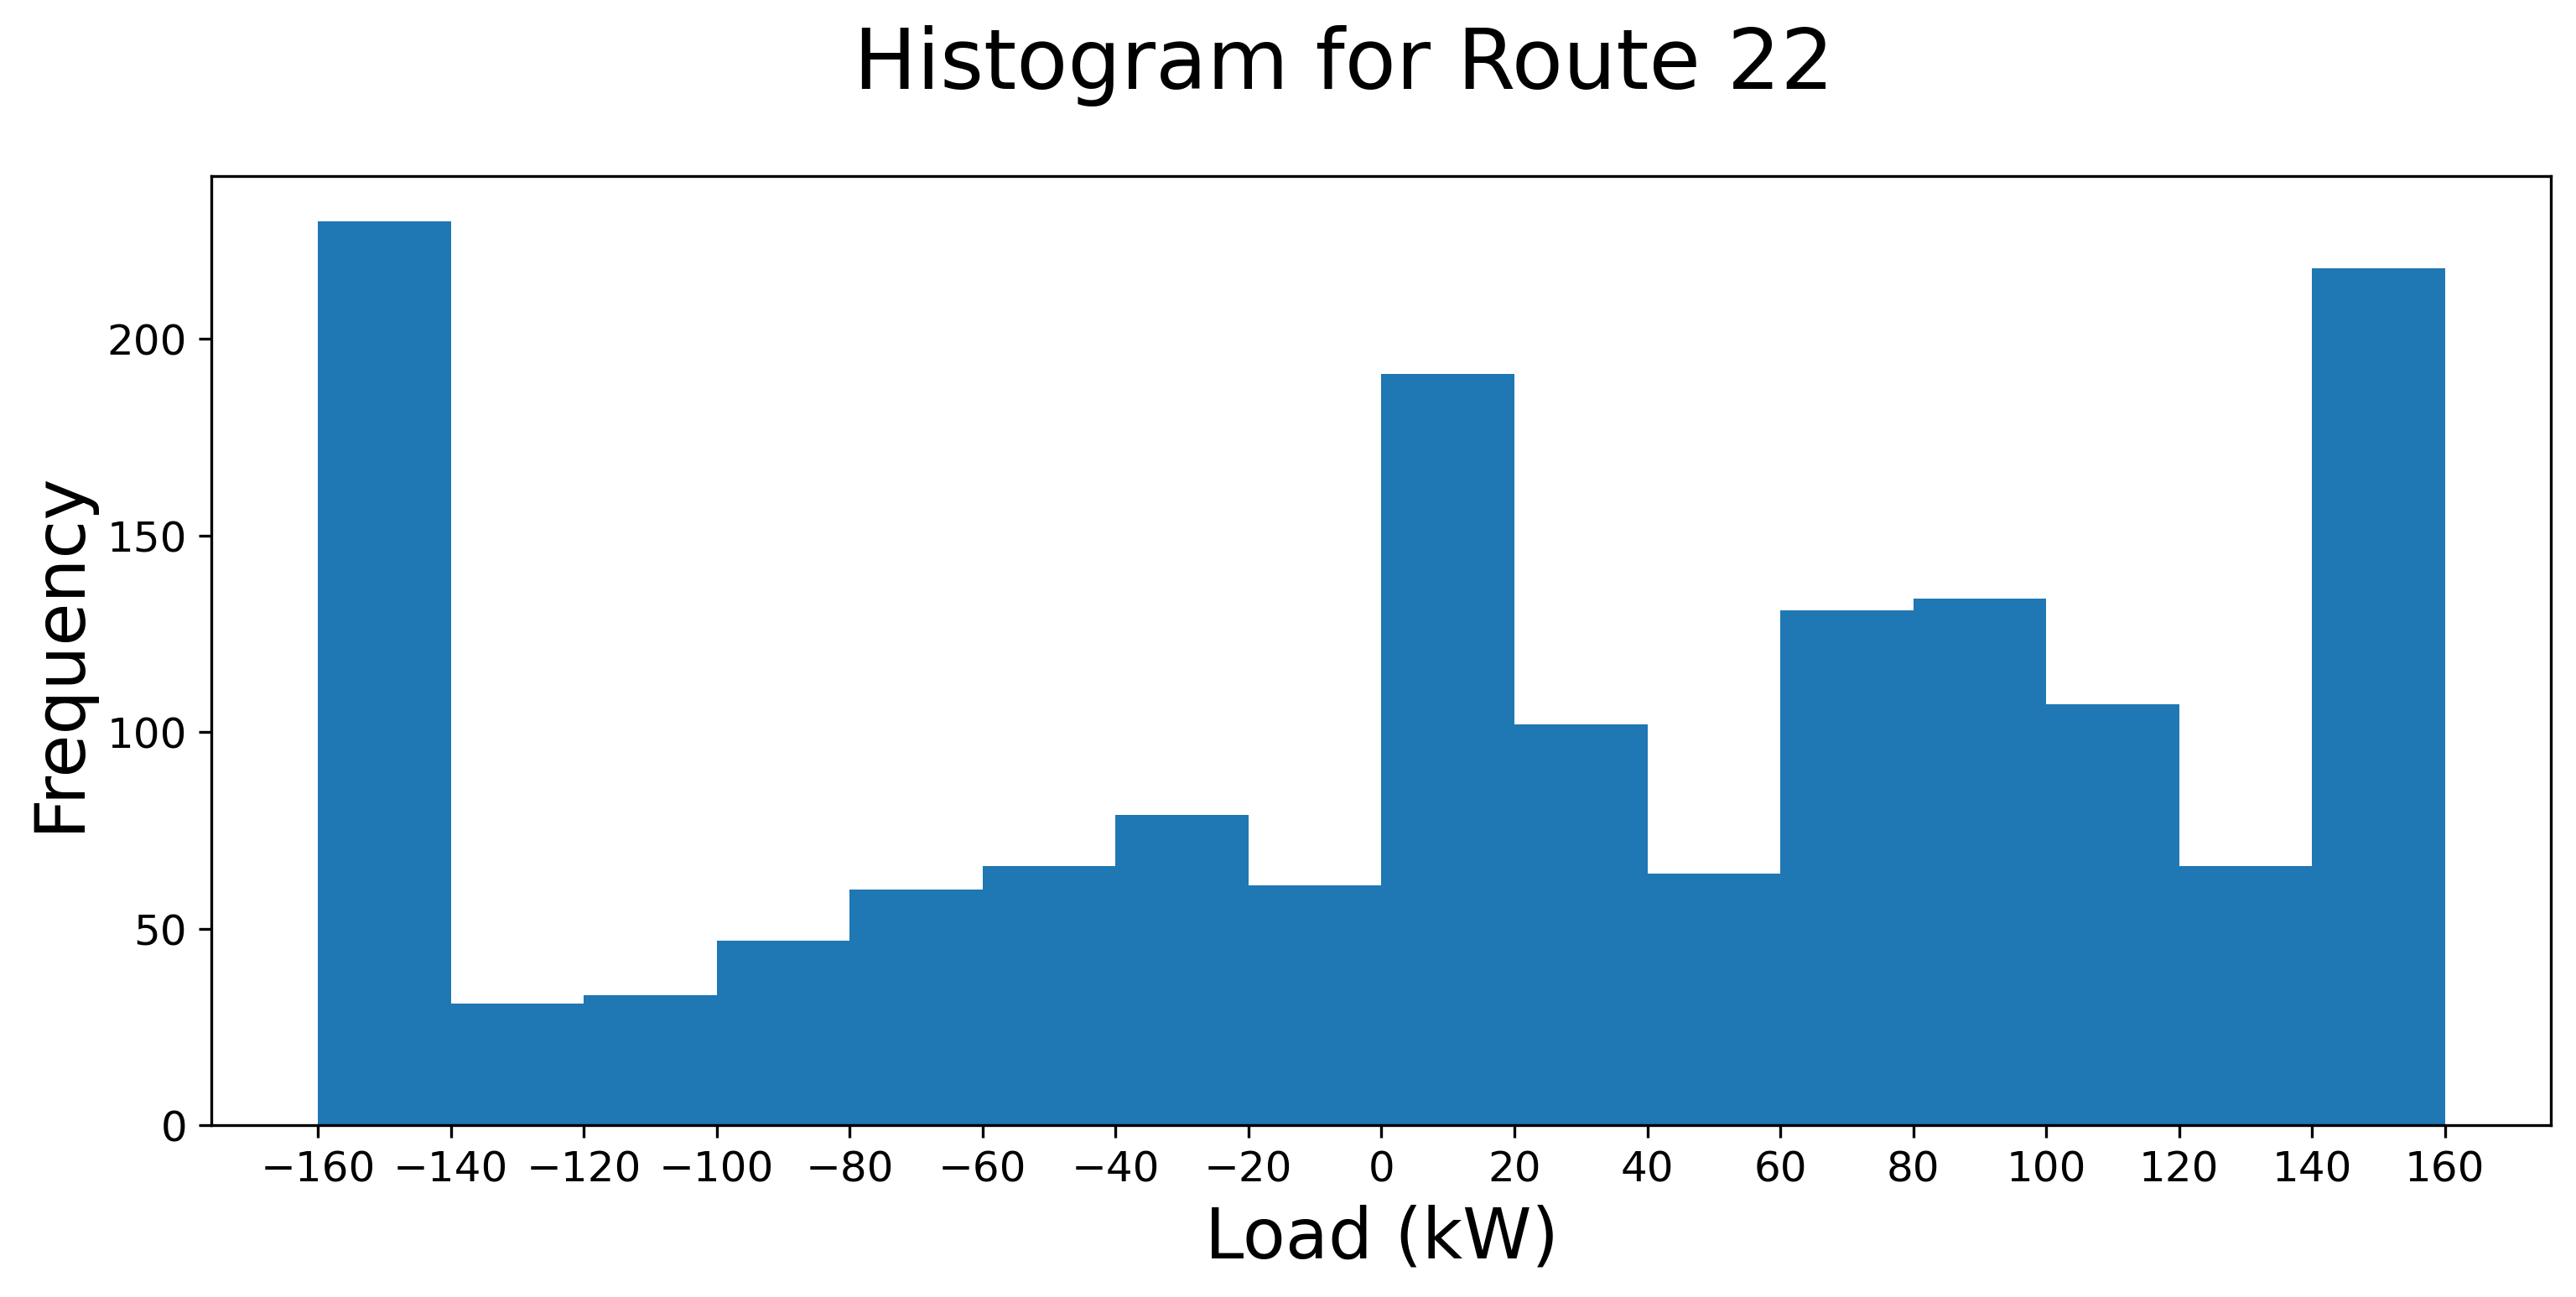

In [22]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

bins = [-160, -140, -120, -100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160]
ax.hist(rt_df['power_output']/1000, bins=bins)
ax.set_ylabel('Frequency', fontsize=20)
ax.set_xlabel('Load (kW)', fontsize=20)
ax.tick_params(labelsize=12)
ax.set_xticks(bins)

fig.suptitle(
    'Histogram for Route {}'.format(route),
    fontsize=24,
    y=1,
    )

In [23]:
ex.energy_from_route(rt_df)

27.637430829928668